<h1>Kia Models Segmentation using UNET with PyTorch<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualization-Images-with-their-Mask" data-toc-modified-id="Visualization-Images-with-their-Mask-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualization Images with their Mask</a></span></li><li><span><a href="#Train-and-validation-data-preparation" data-toc-modified-id="Train-and-validation-data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train and validation data preparation</a></span></li><li><span><a href="#Dataset-Class" data-toc-modified-id="Dataset-Class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset Class</a></span></li><li><span><a href="#Dataloader-creation" data-toc-modified-id="Dataloader-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataloader creation</a></span></li><li><span><a href="#Model-preparation" data-toc-modified-id="Model-preparation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model preparation</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training and Validation</a></span></li><li><span><a href="#Saving-Model" data-toc-modified-id="Saving-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving Model</a></span></li><li><span><a href="#Model-test" data-toc-modified-id="Model-test-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model test</a></span></li></ul></div>

In [69]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import albumentations as A

from PIL import Image
from tqdm.auto import tqdm
from torchvision import models
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

### Visualization Images with their Mask

In [70]:
img_path = '/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train'
mask_path = '/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks'

In [71]:
train_img_lst = os.listdir(img_path) 
train_mask_lst = os.listdir(mask_path)

In [72]:
print(train_mask_lst[:5])
print(train_img_lst[:5])

['aug_4_sportage_mask_1.png', 'aug_3_sportage_mask_4.png', 'aug_4_k9_mask_1.png', 'aug_3_sorento_mask_1.png', 'aug_3_picanto_mask_2.png']
['aug_1_k9_4.png', 'aug_0_k9_4.png', 'aug_5_sorento_3.png', 'aug_4_k5_3.png', 'aug_5_k5_3.png']


In [73]:
print(len(train_mask_lst))
print(len(train_img_lst))

309
309


In [75]:
sorted_train_img_lst = sorted(train_img_lst)
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst.remove('.DS_Store')
sorted_train_mask_lst.remove('.DS_Store')

In [76]:
print(sorted_train_img_lst[:5])
print(sorted_train_mask_lst[:5])

['aug_0_carnival_1.png', 'aug_0_carnival_2.png', 'aug_0_carnival_3.png', 'aug_0_carnival_4.png', 'aug_0_ceed_1.png']
['aug_0_carnival_mask_1.png', 'aug_0_carnival_mask_2.png', 'aug_0_carnival_mask_3.png', 'aug_0_carnival_mask_4.png', 'aug_0_ceed_mask_1.png']


In [77]:
def show_images(imgs_lst, masks_lst, loops=1):
    for i in range(loops):
        img_path = os.path.join('/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train', imgs_lst[i])
        mask_path = os.path.join('/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks', masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()

/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train/aug_0_carnival_1.png
(490, 490)
<class 'PIL.PngImagePlugin.PngImageFile'>


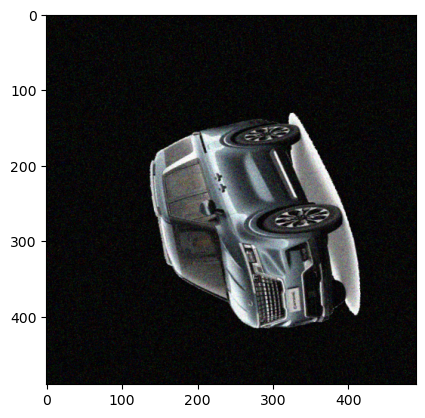

/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks/aug_0_carnival_mask_1.png
(490, 490)


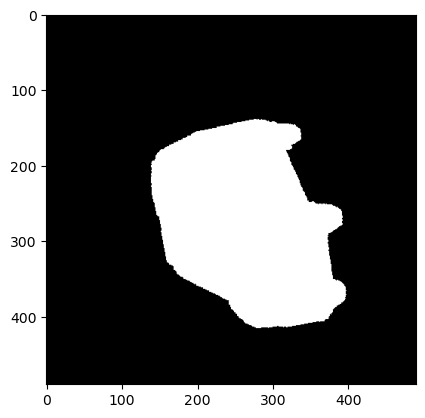

In [78]:
show_images(sorted_train_img_lst, sorted_train_mask_lst)

### Train and validation data preparation

In [378]:
class Preparation:
    device = (torch.device('mps') if torch.backends.mps.is_available()
          else torch.device('cpu'))
    split_pct = 0.2
    learning_rate = 1e-5
    batch_size = 1
    epochs = 5

In [379]:
seed = 1204
np.random.seed(seed)
torch.manual_seed(seed)

In [380]:
Preparation.device

device(type='mps')

In [381]:
def modification(s):
    hashlist = list(s)
    hashlist.insert(-5, 'mask_')
    return ''.join(hashlist)

In [382]:
permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
permuted_train_mask_lst = [modification(x) for x in permuted_train_img_lst]
print(permuted_train_img_lst[:5])
print(permuted_train_mask_lst[:5])

['aug_6_sorento_1.png' 'aug_0_k5_1.png' 'aug_3_ceed_2.png'
 'aug_4_mohave_1.png' 'aug_1_mohave_4.png']
['aug_6_sorento_mask_1.png', 'aug_0_k5_mask_1.png', 'aug_3_ceed_mask_2.png', 'aug_4_mohave_mask_1.png', 'aug_1_mohave_mask_4.png']


/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train/aug_6_sorento_1.png
(490, 490)
<class 'PIL.PngImagePlugin.PngImageFile'>


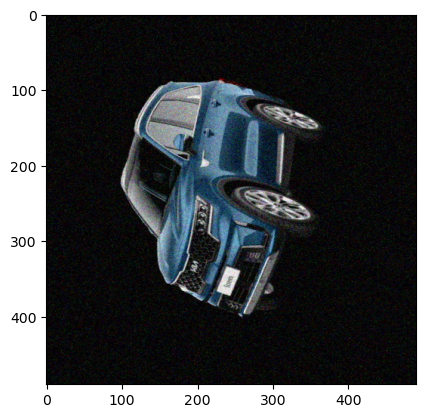

/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks/aug_6_sorento_mask_1.png
(490, 490)


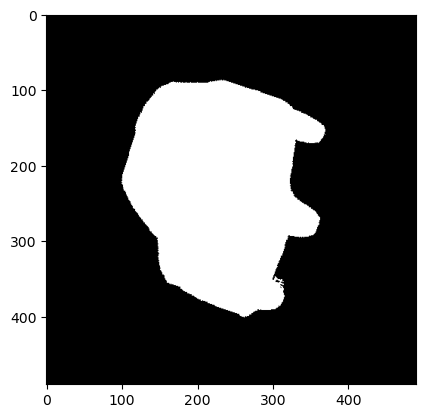

In [383]:
show_images(permuted_train_img_lst, permuted_train_mask_lst)

In [384]:
train_images_list = permuted_train_img_lst[int(Preparation.split_pct*len(permuted_train_img_lst)) :]
train_masks_list = permuted_train_mask_lst[int(Preparation.split_pct*len(permuted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = permuted_train_img_lst[: int(Preparation.split_pct*len(permuted_train_img_lst))]
val_masks_list = permuted_train_mask_lst[: int(Preparation.split_pct*len(permuted_train_mask_lst))]
print(len(val_masks_list))

247
61


/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train/aug_3_sorento_2.png
(490, 490)
<class 'PIL.PngImagePlugin.PngImageFile'>


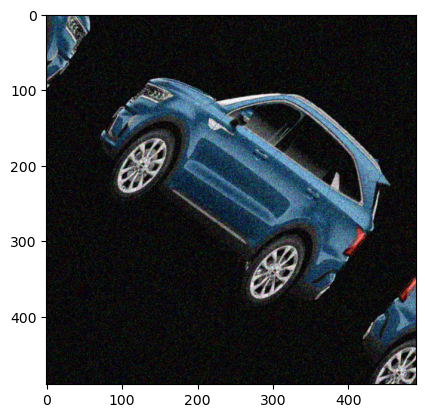

/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks/aug_3_sorento_mask_2.png
(490, 490)


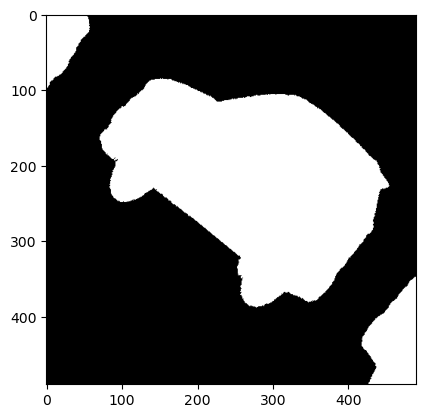

In [385]:
show_images(train_images_list, train_masks_list)

/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train/aug_6_sorento_1.png
(490, 490)
<class 'PIL.PngImagePlugin.PngImageFile'>


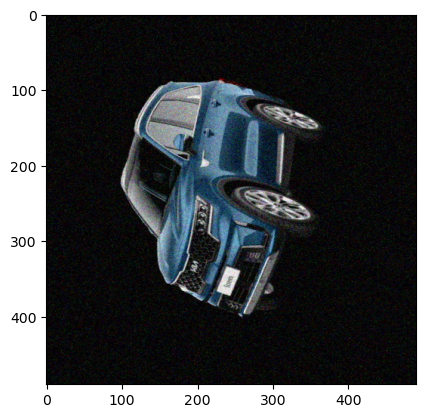

/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks/aug_6_sorento_mask_1.png
(490, 490)


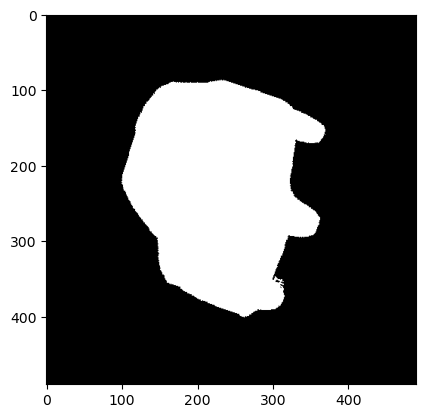

In [386]:
show_images(val_images_list, val_masks_list)

### Dataset Class

In [387]:
class KiaModelsDataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join('/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train',
                                self.img_list[index])
        mask_path = os.path.join('/Users/alexeyfilichkin/Desktop/PyTorch/UNET/model_data_train_masks',
                                 self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
#        mask[mask==255.0] = 1.0
        
        
            
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation['image']
            mask = augmentation['mask']
#            mask = torch.unsqueeze(mask, 0)
            img = torch.tensor(img, dtype=torch.float)
            mask = torch.tensor(mask, dtype=torch.float)
        
            
        return torch.permute(img, (2, 0, 1)), torch.permute(mask, (2, 0, 1))

In [388]:
train_transform = A.Compose([A.Resize(470, 470), 
                             A.Normalize(mean=(0.485, 0.456, 0.406),
                                         std=(0.229, 0.224, 0.225),
                                         max_pixel_value=255),
#                                        ToTensorV2()
                                        ])

val_transform = A.Compose([A.Resize(470, 470),
                           A.Normalize(mean=(0.485, 0.456, 0.406),
                                       std=(0.229, 0.224, 0.225),
                                       max_pixel_value=255),
#                           ToTensorV2()
                           ])

In [389]:
train_dataset = KiaModelsDataset(train_images_list,
                               train_masks_list,
                               transform=train_transform
                              )
val_dataset = KiaModelsDataset(val_images_list,
                               val_masks_list,
                               transform=val_transform
                              )

In [390]:
img, mask = train_dataset[11]

In [391]:
display(img.shape, mask.shape)

torch.Size([3, 470, 470])

torch.Size([3, 470, 470])

In [392]:
mask.max()

tensor(255.)

In [393]:
def show_single_img(img, mask, index=None, train=True):
    if index:
        if train:
            img, mask = train_dataset[index]
        else:
            img, mask = val_dataset[index]
    plt.imshow(img.permute(2, 1, 0))  # Convert (3, 572, 572) -> (572, 572, 3)
    plt.show()
    plt.imshow(mask.permute(2, 1, 0))  # Convert (1, 572, 572) -> (572, 572, 1)
    print(mask.shape)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


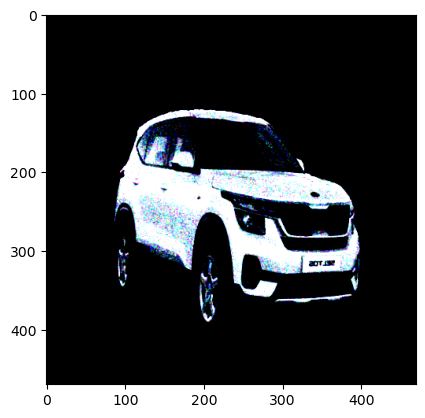

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 470, 470])


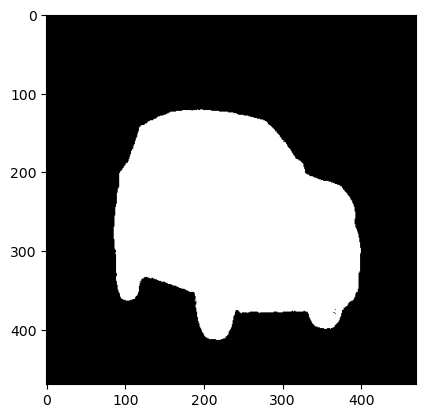

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


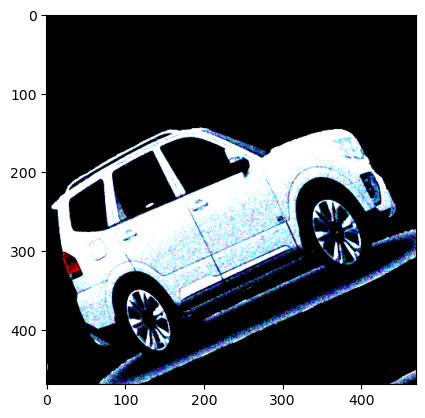

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 470, 470])


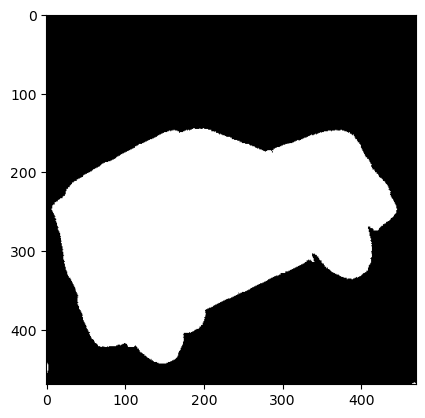

In [394]:
show_single_img(img, mask, index=25, train=False)
show_single_img(img, mask, index=25, train=True)

### Dataloader creation

In [395]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=Preparation.batch_size,
                              shuffle=True
                             )
val_dataloader = DataLoader(val_dataset,
                            batch_size=Preparation.batch_size,
                            shuffle=False
                           )

In [396]:
len(train_dataloader), len(val_dataloader)

(247, 61)

In [397]:
a = iter(train_dataloader)
img, mask = next(a)
print(img.shape, mask.shape)

torch.Size([1, 3, 470, 470]) torch.Size([1, 3, 470, 470])


In [398]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ])

### Model preparation

In [399]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,
                  out_channels=out_ch,
                  kernel_size=3,
                  stride=1,
                  padding=1
                 ),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,
                  out_channels=out_ch,
                  kernel_size=3,
                  stride=1,
                  padding=1
                 ), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

    
def padder(left_tensor, right_tensor): 
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(Preparation.device)
    
    return right_tensor.to(Preparation.device)

In [400]:
class UNET(nn.Module):
    def __init__(self, in_chnls, n_classes):
        super(UNET, self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls, out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64, out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128, out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256, out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512, out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=self.n_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4, d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4, pad1], dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3, d2)
        cat2 = torch.cat([x3, pad2], dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2, d3)
        cat3 = torch.cat([x2, pad3], dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1, d4)
        cat4 = torch.cat([x1, pad4], dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
        #print(conv_1x1.shape)

### Training and Validation

In [401]:
def train_model(model, dataloader, criterion, optimizer):
    model.train()
    train_running_loss = 0.0
    for j, img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(Preparation.device)
        #print(" ----- IMAGE -----")
        #print(img)
        
        mask = img_mask[1]
        mask = data_transforms(mask)
        mask = mask.float().to(Preparation.device)
        #print(" ----- MASK -----")
        #print(mask)
        
        y_pred = model(img)
        #print(" ----- Y PRED -----")
        #print(y_pred)
        #print(" ----- Y PRED SHAPE -----")#
        #print(y_pred.shape)
        optimizer.zero_grad()
        
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item() * Preparation.batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

In [402]:
def val_model(model, dataloader, criterion, optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j, img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(Preparation.device)
            
            mask = img_mask[1]
            mask = data_transforms(mask)
            mask = mask.float().to(Preparation.device)
            y_pred = model(img)
            loss = criterion(y_pred, mask)
            
            val_running_loss += loss.item() * Preparation.batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss

In [403]:
model = UNET(in_chnls = 3, n_classes = 1).to(Preparation.device)
optimizer = optim.Adam(model.parameters(), lr = Preparation.learning_rate)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
val_loss_lst = []  

In [404]:
for i in tqdm(range(Preparation.epochs)):
    train_loss = train_model(model=model,
                             dataloader=train_dataloader,
                             criterion=criterion,
                             optimizer=optimizer
                            )
    val_loss = val_model(model=model,
                         dataloader=val_dataloader,
                         criterion=criterion,
                         optimizer=optimizer
                        )
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

 Train Loss : -130.1327
 Validation Loss : -200.8196


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

 Train Loss : -215.7952
 Validation Loss : -236.9433


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

 Train Loss : -239.7658
 Validation Loss : -233.8698


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

 Train Loss : -254.2989
 Validation Loss : -240.4832


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

 Train Loss : -266.9433
 Validation Loss : -241.0647


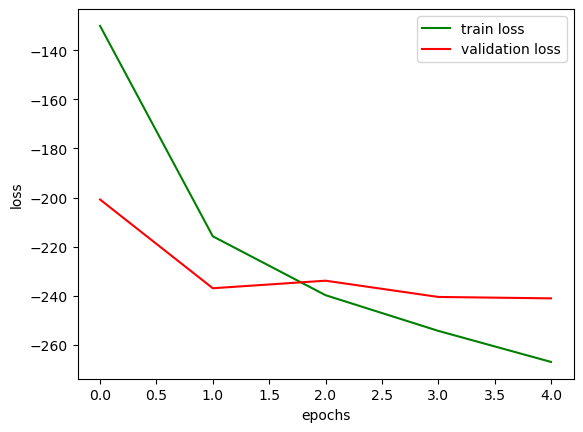

In [405]:
plt.plot(train_loss_lst, color="green", label='train loss')
plt.plot(val_loss_lst, color="red", label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

### Saving Model

In [407]:
torch.save(model.state_dict(), '/Users/alexeyfilichkin/Desktop/PyTorch/UNET/unet_scratch.pth')

### Model test

In [408]:
trained_model = UNET(in_chnls=3, n_classes=1)

In [409]:
trained_model.load_state_dict(torch.load('/Users/alexeyfilichkin/Desktop/PyTorch/UNET/unet_scratch.pth'))

/var/folders/rh/t5mb2sd16vx4tdlfd33x10mm0000gn/T/ipykernel_2859/3223137104.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('/Use

<All keys matched successfully>

In [410]:
trained_model = trained_model.to('mps')
trained_model.eval()

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [463]:
img_path = '/Users/alexeyfilichkin/Desktop/PyTorch/UNET/2014-kia-optima_100425708_h.jpg'

img = cv2.imread(img_path)

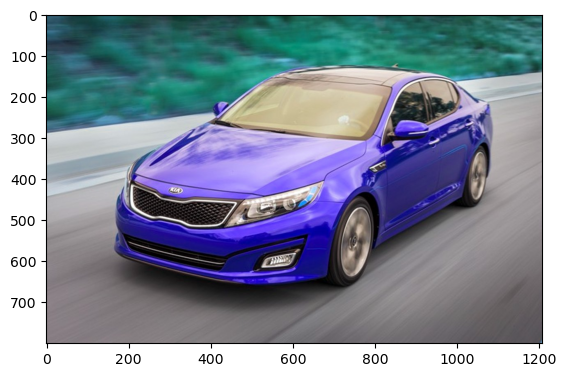

In [464]:
plt.imshow(img)
plt.show()

In [465]:
test_transform = A.Compose([A.Resize(470, 470), 
                            A.Normalize(mean=(0.485, 0.456, 0.406),
                                        std=(0.229, 0.224, 0.225),
                                        max_pixel_value=255),
                            ToTensorV2()
                            ])

In [466]:
test_image = test_transform(image=img)

print(test_image)

print(test_image['image'].dtype)
print(test_image['image'].shape)

{'image': tensor([[[-1.2617, -1.2788, -1.2617,  ..., -1.2274, -1.2788, -1.2103],
         [-1.2959, -1.2959, -1.2959,  ..., -1.1760, -1.2103, -1.1418],
         [-1.3130, -1.3302, -1.3130,  ..., -1.2445, -1.2274, -1.1760],
         ...,
         [ 0.2111,  0.1939,  0.1426,  ..., -0.7308, -0.9363, -0.5767],
         [ 0.2796,  0.2453,  0.2453,  ..., -0.8164, -0.7822, -0.4226],
         [ 0.2282,  0.1768,  0.2453,  ..., -0.9020, -0.6623, -0.3883]],

        [[-0.2850, -0.2850, -0.3025,  ..., -0.2325, -0.2850, -0.2150],
         [-0.3200, -0.3200, -0.3375,  ..., -0.1275, -0.1625, -0.0924],
         [-0.3375, -0.3550, -0.3725,  ..., -0.1800, -0.1625, -0.1099],
         ...,
         [ 0.1702,  0.1527,  0.1001,  ..., -0.5651, -0.5476,  0.1001],
         [ 0.2402,  0.2052,  0.1877,  ..., -0.5651, -0.2850,  0.3978],
         [ 0.1877,  0.1352,  0.2052,  ..., -0.6176, -0.1099,  0.5203]],

        [[ 0.3219,  0.3045,  0.3045,  ..., -0.0790, -0.1312, -0.0615],
         [ 0.2871,  0.2871,  0.2696

In [467]:
img = test_image['image'].unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 470, 470])


In [468]:
img = img.to('mps')

In [469]:
pred = trained_model(img)
pred.shape

torch.Size([1, 1, 470, 470])

In [470]:
mask = pred.squeeze(0).cpu().detach().numpy()
print(mask.shape)
mask = mask.transpose(1, 2, 0)
print(mask.shape)

(1, 470, 470)
(470, 470, 1)


In [471]:
display_test_img = test_image['image'].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1, 2, 0)
display_test_img.shape

(3, 470, 470)


(470, 470, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


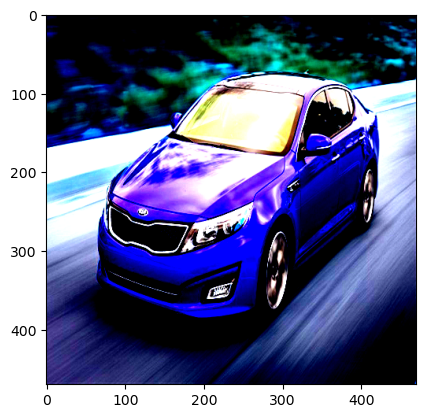

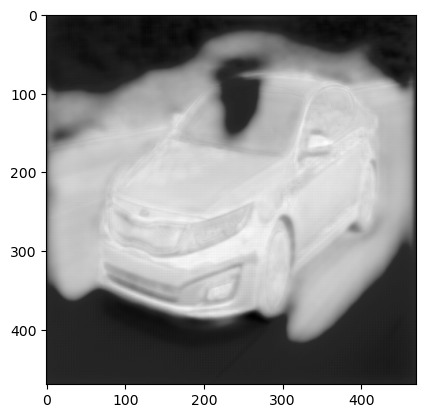

In [472]:
plt.imshow(display_test_img, cmap='gray')
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()